# Galaxy-Quasar Classification

Author: Muhammad Fauzan Ishlah

#### Library and Data preparation

In [5]:
# !pip install astropy

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from astropy.table import Table
import astropy.io.fits as fits
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import set_config

In [7]:
# data_url = 'https://anirut.space/data/sdss_galaxy_qso.fits' 

file = 'sdss_galaxy_qso.fits'
hdul = fits.open(file) 
data = hdul[1].data

##### Data Exploration

In [8]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  120 / width of table in bytes                        
NAXIS2  =                61843 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   18 / number of columns                              
EXTNAME = 'C:\Users\t_ton\Desktop\school\Skyserver_SQL8_2_2021 12_32_19 PM.f...'
TTYPE1  = 'objid   '           / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'ra      '           / label for column 2                             
TFORM2  = 'D       '        

##### Parameter that we will use

In [9]:
ra = data["ra"]
dec = data["dec"]
u = data['u']
g = data['g']
r = data['r']
i = data['i']
z = data['z']
obj_class = data["class"]
n = len(u)
print('Data size: {}'.format(n))

Data size: 61843


##### Assign class object for classification, where Galaxy = 0 and Quasar = 1

In [10]:
object_class = np.empty(n)
for j in range(0, n):
    if obj_class[j] == "GALAXY":
        object_class[j] = 0.0
    elif obj_class[j] == "QSO":
        object_class[j] = 1.0
    else:
        print(j)

Total QSO and Galaxy

Total QSO: 10603
Total GALAXY: 51240


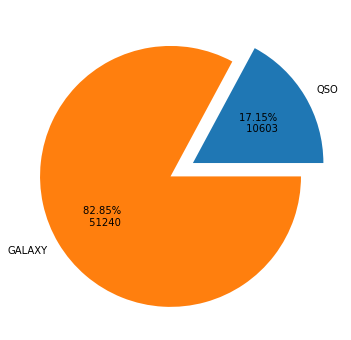

In [11]:
total_qso = (object_class == 1.0).sum()
total_glx = (object_class == 0.0).sum()
total_class = [total_qso, total_glx]
print('Total QSO: {}'.format(total_qso))
print('Total GALAXY: {}'.format(total_glx))
label_class = ['QSO', 'GALAXY']

def make_pct(values):
    def my_pct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n {v:d}'.format(p=pct,v=val)
    return my_pct

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(total_class, labels=label_class, explode= (0.1, 0.1), autopct=make_pct(total_class))
plt.show()

Position of each data in sky coordinate (RA vs DEC)

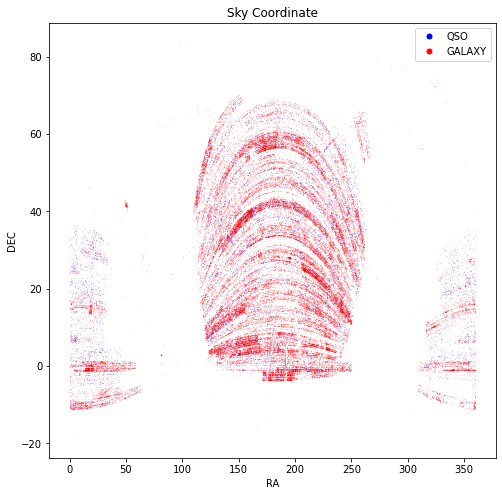

In [12]:
slct_qso = (object_class == 1.0)
slct_glx = (object_class == 0.0)
fig = plt.figure(figsize=(8,8))
plt.plot(ra[slct_qso], dec[slct_qso], 'b.', markersize=0.1, label='QSO')
plt.plot(ra[slct_glx], dec[slct_glx], 'r.', markersize=0.1, label='GALAXY')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(markerscale = 100)
plt.title('Sky Coordinate')
plt.show()

#### Color band relation
- ($u – g$) vs ($g – r$) 
- ($r – i$) vs ($i – z$)

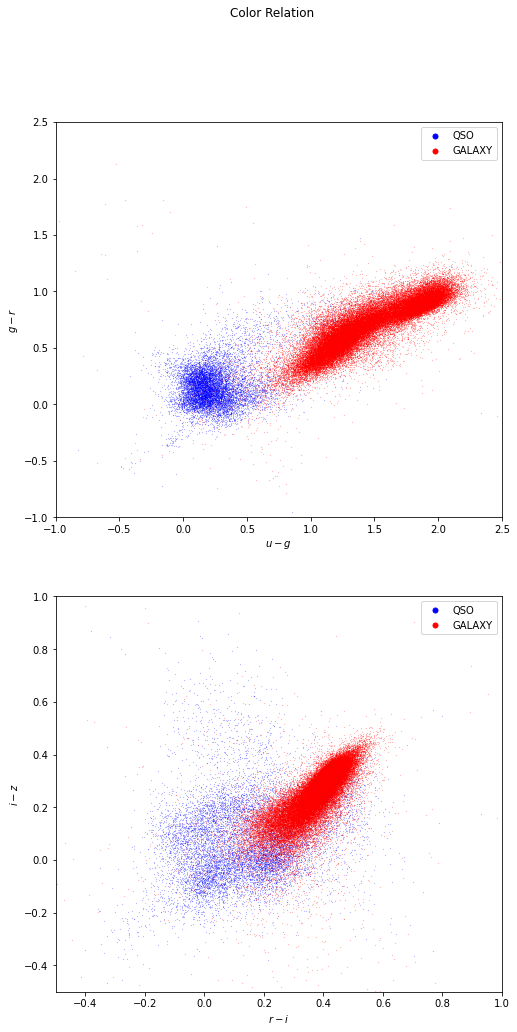

In [13]:
ug = u - g
gr = g - r
ri = r-i
iz = i-z

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,16))
ax1.plot(ug[slct_qso], gr[slct_qso], 'b.', markersize = 0.2, label = 'QSO')
ax1.plot(ug[slct_glx], gr[slct_glx], 'r.', markersize = 0.2, label = 'GALAXY')


ax2.plot(ri[slct_qso], iz[slct_qso], 'b.', markersize = 0.2, label = 'QSO')
ax2.plot(ri[slct_glx], iz[slct_glx], 'r.', markersize = 0.2, label = 'GALAXY')

ax1.set_xlim(-1, 2.5)
ax1.set_ylim(-1, 2.5)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

ax2.set_xlim(-0.5, 1)
ax2.set_ylim(-0.5, 1)
ax2.set_xlabel('$r - i$')
ax2.set_ylabel('$i - z$')

ax1.legend(markerscale = 50)
ax2.legend(markerscale = 50)

plt.suptitle('Color Relation')
plt.show()

#### Further Exploratory

In [51]:
data = {
    'u':u,
    'g':g,
    'r':r,
    'i':i,
    'z':z,
    'u-g':ug,
    'g-r':gr,
    'r-i':ri,
    'i-z':iz,
    'type':object_class
}
df = pd.DataFrame(data)
df.head()

,u,g,r,i,z,u-g,g-r,r-i,i-z,type
0,19.422102,18.037611,17.302042,16.922455,16.677103,1.384491,0.735569,0.379587,0.245352,0.0
1,18.116714,16.294020,15.389746,14.937709,14.541996,1.822695,0.904274,0.452037,0.395713,0.0
2,19.146093,18.174807,17.540287,17.134384,16.936029,0.971287,0.634520,0.405903,0.198355,0.0
3,19.033842,17.373066,16.471859,16.012363,15.632732,1.660776,0.901207,0.459496,0.379631,0.0
4,17.976332,16.705133,16.056387,15.692312,15.426526,1.271198,0.648746,0.364075,0.265786,0.0


Since the data from '.fits' are '<F4', I need to convert it

In [58]:
df = df.astype('float32')
df.dtypes

u       float32
g       float32
r       float32
i       float32
z       float32
u-g     float32
g-r     float32
r-i     float32
i-z     float32
type    float32
dtype: object

##### Correlation between data

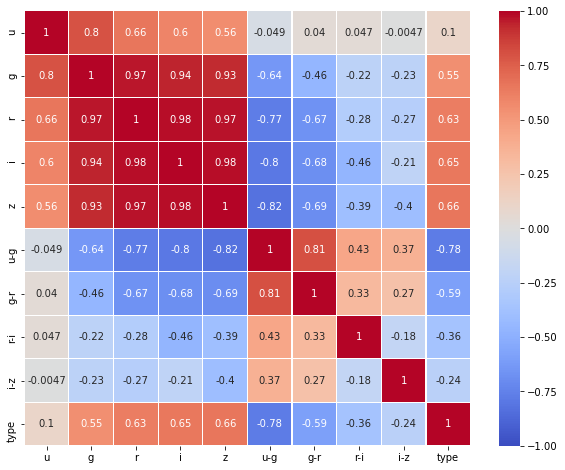

In [59]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

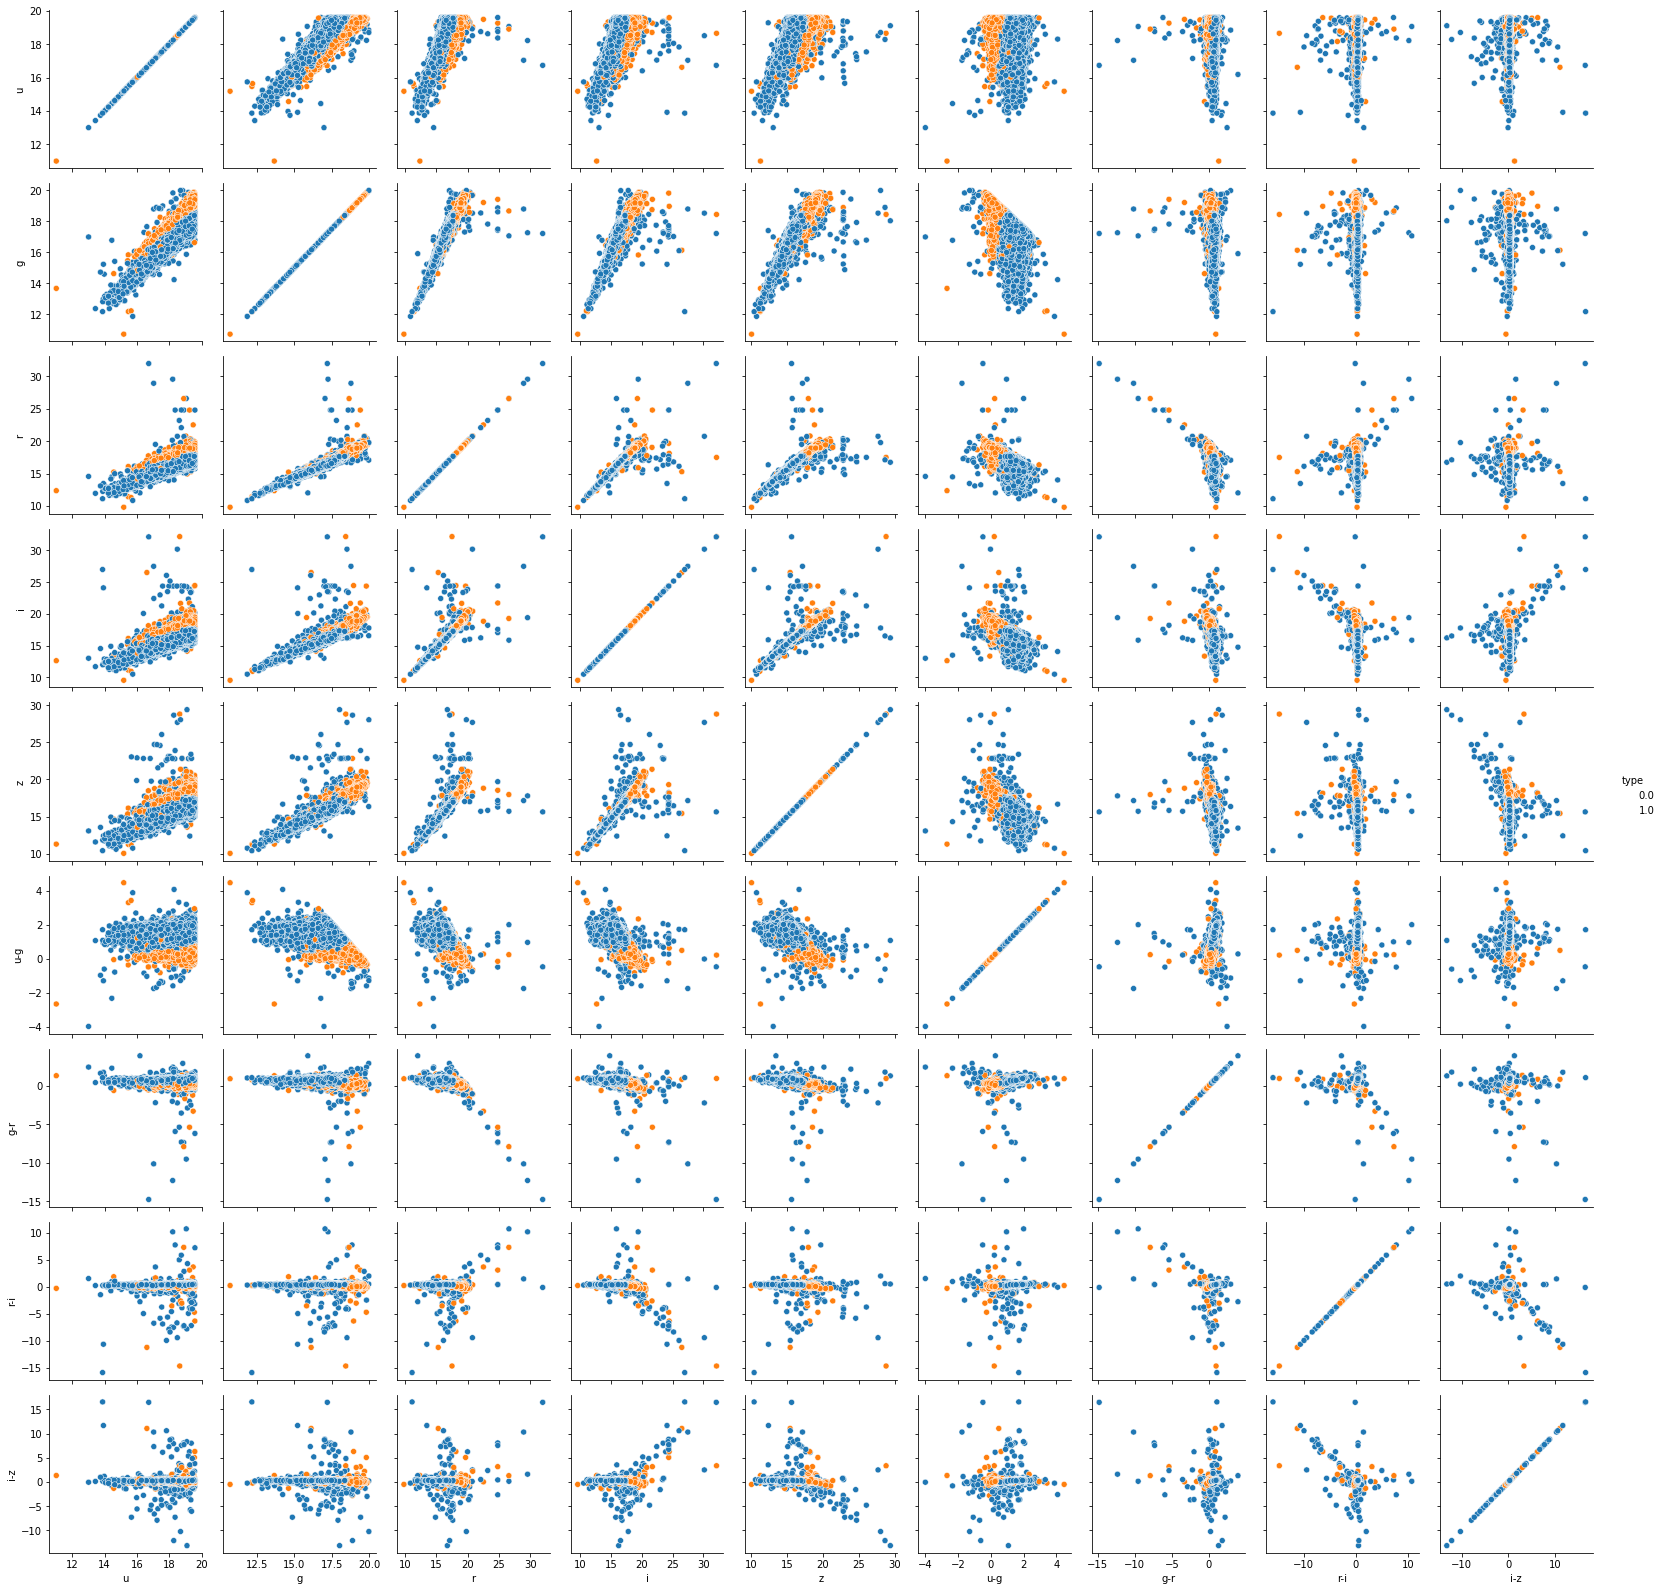

In [65]:
grid=sns.PairGrid(data=df, hue='type')
grid.map(sns.scatterplot)
grid.add_legend()

#### Feature Selection
In this project, I use color band and color band relation as the features

In [82]:
features = df.drop('type', axis=1)
object_class = df['type']

##### Data split

In [83]:
x_train, x_test, y_train, y_test = train_test_split(features, object_class, test_size=0.3)

#### Model Selection
For model selection, I test it for KNN Classifier

##### Selecting model

In [35]:
set_config(display="diagram")

In [100]:
my_classifier = Pipeline([
    ('Scalar',StandardScaler()),
    ('PCA',PCA()),
    ('KNN',KNeighborsClassifier())
])

In [101]:
my_classifier.fit(x_train, y_train)

Pipeline(steps=[('Scalar', StandardScaler()), ('PCA', PCA()),
                ('KNN', KNeighborsClassifier())])

##### Classifier Performance

In [102]:
y_predict=my_classifier.predict(x_test)
target_labels=['Galaxy', 'Quasar']
report = classification_report(y_test, y_predict, target_names=target_labels)
print(report)

              precision    recall  f1-score   support

      Galaxy       0.99      0.99      0.99     15395
      Quasar       0.97      0.94      0.95      3158

    accuracy                           0.98     18553
   macro avg       0.98      0.97      0.97     18553
weighted avg       0.98      0.98      0.98     18553



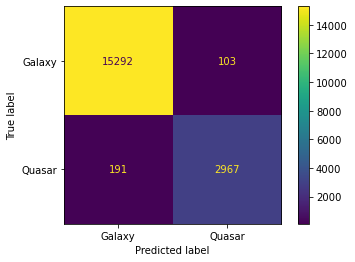

In [99]:
cm = confusion_matrix(y_test, y_predict)
conf = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels=target_labels
)
conf.plot()
plt.show()

### Comparing few models: KNN, SVC, RandomForest

In [207]:
pipe_knn = Pipeline([
    ('Scalar',StandardScaler()),
    ('PCA',PCA()),
    ('clf',KNeighborsClassifier())
])

pipe_rf = Pipeline([
    ('Scalar',StandardScaler()),
    ('PCA',PCA()),
    ('clf',RandomForestClassifier())
]) 

pipe_svc = Pipeline([
    ('Scalar',StandardScaler()),
    ('PCA',PCA()),
    ('clf',SVC())
]) 

pipes = [pipe_knn, pipe_rf, pipe_svc]
pipe_name = ['KNN', 'RF', 'SVC']

In [208]:
for i in range(len(pipes)):
    pipes[i].fit(x_train, y_train)
    print(f'----------------------- \n {pipe_name[i]}')
    y_pred=pipes[i].predict(x_test)
    print(classification_report(y_test, y_pred, target_names=target_labels))

----------------------- 
 KNN
              precision    recall  f1-score   support

      Galaxy       0.99      0.99      0.99     15395
      Quasar       0.97      0.94      0.95      3158

    accuracy                           0.98     18553
   macro avg       0.98      0.97      0.97     18553
weighted avg       0.98      0.98      0.98     18553

----------------------- 
 RF
              precision    recall  f1-score   support

      Galaxy       0.99      0.99      0.99     15395
      Quasar       0.96      0.94      0.95      3158

    accuracy                           0.98     18553
   macro avg       0.98      0.97      0.97     18553
weighted avg       0.98      0.98      0.98     18553

----------------------- 
 SVC
              precision    recall  f1-score   support

      Galaxy       0.99      0.99      0.99     15395
      Quasar       0.97      0.94      0.95      3158

    accuracy                           0.98     18553
   macro avg       0.98      0.97      

With default parameter, the models have similar score <br>
Now, find the best parameter for each models

#### Parameter

In [182]:
param_knn = {
    "PCA__n_components": [5, 6, 7, 8, 9],
    "clf__n_neighbors": [5, 6, 7, 8, 9, 10],
}
param_rf = {
    "PCA__n_components": [5, 6, 7, 8, 9],
    "clf__n_estimators": [50,100],
    "clf__criterion":["gini", "entropy"]
}
param_svc = {
    "PCA__n_components": [5, 6, 7, 8, 9],
    "clf__kernel":['linear', 'poly','rbf'],
    "clf__random_state":[0,]
}

#### Grid search using all processors

In [137]:
# KNN
search_knn = GridSearchCV(
    pipe_knn, 
    param_knn, 
    cv=5,
    verbose=4,
    n_jobs=-1
)

In [138]:
search_knn.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scalar', StandardScaler()),
                                       ('PCA', PCA()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'PCA__n_components': [5, 6, 7, 8, 9],
                         'clf__n_neighbors': [5, 6, 7, 8, 9, 10]},
             verbose=4)

In [165]:
param_knn_result = pd.DataFrame(search_knn.cv_results_)
param_knn_result.sample(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_PCA__n_components,param_clf__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.243694,0.021190,1.150724,0.045515,7,5,"{'PCA__n_components': 7, 'clf__n_neighbors': 5}",0.983368,0.984292,0.984407,0.983137,0.983021,0.983645,0.000587,11
10,0.209326,0.012497,1.105987,0.057946,6,9,"{'PCA__n_components': 6, 'clf__n_neighbors': 9}",0.983252,0.983945,0.984869,0.983252,0.983483,0.983761,0.000609,6


In [181]:
param_knn_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_PCA__n_components,param_clf__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.185934,0.011052,0.886378,0.033061,5,5,"{'PCA__n_components': 5, 'clf__n_neighbors': 5}",0.983368,0.984292,0.984407,0.983137,0.983021,0.983645,0.000587,11
1,0.196930,0.012546,0.933213,0.026778,5,6,"{'PCA__n_components': 5, 'clf__n_neighbors': 6}",0.983252,0.983483,0.984407,0.983483,0.982675,0.983460,0.000558,16
2,0.190580,0.011692,0.959148,0.043741,5,7,"{'PCA__n_components': 5, 'clf__n_neighbors': 7}",0.982906,0.984523,0.984754,0.983483,0.983714,0.983876,0.000680,1
3,0.178083,0.007653,0.965396,0.030291,5,8,"{'PCA__n_components': 5, 'clf__n_neighbors': 8}",0.983137,0.983483,0.984523,0.983368,0.982790,0.983460,0.000582,16
4,0.181207,0.007654,0.974769,0.037749,5,9,"{'PCA__n_components': 5, 'clf__n_neighbors': 9}",0.983252,0.983945,0.984869,0.983252,0.983483,0.983761,0.000609,6
5,0.190580,0.006249,0.999763,0.060094,5,10,"{'PCA__n_components': 5, 'clf__n_neighbors': 10}",0.983252,0.982790,0.984523,0.983368,0.983252,0.983437,0.000578,26
6,0.215575,0.011691,0.990390,0.091940,6,5,"{'PCA__n_components': 6, 'clf__n_neighbors': 5}",0.983368,0.984292,0.984407,0.983137,0.983021,0.983645,0.000587,11
7,0.203078,0.017112,1.021633,0.070279,6,6,"{'PCA__n_components': 6, 'clf__n_neighbors': 6}",0.983252,0.983483,0.984407,0.983483,0.982675,0.983460,0.000558,16
8,0.203077,0.013973,1.043503,0.024993,6,7,"{'PCA__n_components': 6, 'clf__n_neighbors': 7}",0.982906,0.984523,0.984754,0.983483,0.983714,0.983876,0.000680,1
9,0.203077,0.000001,1.027882,0.065832,6,8,"{'PCA__n_components': 6, 'clf__n_neighbors': 8}",0.983137,0.983483,0.984523,0.983368,0.982790,0.983460,0.000582,16


Rank 1 parameter

In [167]:
param_knn_result.loc[param_knn_result['rank_test_score']==param_knn_result['rank_test_score'].min()].sort_values(by='mean_fit_time')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_PCA__n_components,param_clf__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.190580,0.011692,0.959148,0.043741,5,7,"{'PCA__n_components': 5, 'clf__n_neighbors': 7}",0.982906,0.984523,0.984754,0.983483,0.983714,0.983876,0.00068,1
8,0.203077,0.013973,1.043503,0.024993,6,7,"{'PCA__n_components': 6, 'clf__n_neighbors': 7}",0.982906,0.984523,0.984754,0.983483,0.983714,0.983876,0.00068,1
20,0.221822,0.006247,1.187219,0.098302,8,7,"{'PCA__n_components': 8, 'clf__n_neighbors': 7}",0.982906,0.984523,0.984754,0.983483,0.983714,0.983876,0.00068,1
26,0.243691,0.012499,1.392608,0.067204,9,7,"{'PCA__n_components': 9, 'clf__n_neighbors': 7}",0.982906,0.984523,0.984754,0.983483,0.983714,0.983876,0.00068,1
14,0.245856,0.012817,1.231204,0.049150,7,7,"{'PCA__n_components': 7, 'clf__n_neighbors': 7}",0.982906,0.984523,0.984754,0.983483,0.983714,0.983876,0.00068,1


In [183]:
# RandomForest
search_rf = GridSearchCV(
    pipe_rf, 
    param_rf, 
    cv=5,
    verbose=4,
    n_jobs=-1
)

In [184]:
search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scalar', StandardScaler()),
                                       ('PCA', PCA()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'PCA__n_components': [5, 6, 7, 8, 9],
                         'clf__criterion': ['gini', 'entropy'],
                         'clf__n_estimators': [50, 100]},
             verbose=4)

In [188]:
param_rf_result = pd.DataFrame(search_rf.cv_results_)
param_rf_result.loc[param_rf_result['rank_test_score']==1].sort_values(by='mean_fit_time')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_PCA__n_components,param_clf__criterion,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,19.580484,0.228473,0.16871,0.006249,5,entropy,100,"{'PCA__n_components': 5, 'clf__criterion': 'en...",0.983021,0.985331,0.985216,0.984061,0.982097,0.983945,0.00125,1


In [187]:
# SVC
search_svc = GridSearchCV(
    pipe_svc, 
    param_svc, 
    cv=5,
    verbose=4,
    n_jobs=-1
)

In [189]:
search_svc.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scalar', StandardScaler()),
                                       ('PCA', PCA()), ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'PCA__n_components': [5, 6, 7, 8, 9],
                         'clf__kernel': ['linear', 'poly', 'rbf'],
                         'clf__random_state': [0]},
             verbose=4)

In [190]:
param_svc_result=pd.DataFrame(search_svc.cv_results_)
param_svc_result.loc[param_svc_result['rank_test_score']==1].sort_values(by='mean_fit_time')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_PCA__n_components,param_clf__kernel,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,7.446716,0.138762,3.849591,0.041631,8,rbf,0,"{'PCA__n_components': 8, 'clf__kernel': 'rbf',...",0.98383,0.983599,0.986255,0.983599,0.983137,0.984084,0.001109,1
14,7.821441,0.154549,3.886347,0.071820,9,rbf,0,"{'PCA__n_components': 9, 'clf__kernel': 'rbf',...",0.98383,0.983599,0.986255,0.983599,0.983137,0.984084,0.001109,1


Get best parameter for each model

In [195]:
best_knn = param_knn_result.loc[param_knn_result['rank_test_score']==1].sort_values(by='mean_fit_time').iloc[0]['params']
best_rf = param_rf_result.loc[param_rf_result['rank_test_score']==1].sort_values(by='mean_fit_time').iloc[0]['params']
best_svc = param_svc_result.loc[param_svc_result['rank_test_score']==1].sort_values(by='mean_fit_time').iloc[0]['params']

In [197]:
print(best_knn)
print(best_rf)
print(best_svc)

{'PCA__n_components': 5, 'clf__n_neighbors': 7}
{'PCA__n_components': 5, 'clf__criterion': 'entropy', 'clf__n_estimators': 100}
{'PCA__n_components': 8, 'clf__kernel': 'rbf', 'clf__random_state': 0}


 Create pipelines for each model with best parameter

In [199]:
pipe_knn_best = Pipeline([
    ('Scalar',StandardScaler()),
    ('PCA',PCA(n_components=5)),
    ('clf',KNeighborsClassifier(n_neighbors=7))
])

pipe_rf_best = Pipeline([
    ('Scalar',StandardScaler()),
    ('PCA',PCA(n_components=5)),
    ('clf',RandomForestClassifier(criterion='entropy', n_estimators=100))
]) 

pipe_svc_best = Pipeline([
    ('Scalar',StandardScaler()),
    ('PCA',PCA(n_components=8)),
    ('clf',SVC(kernel='rbf', random_state=0))
]) 

pipelines_best = [pipe_knn_best, pipe_rf_best, pipe_svc_best]

In [200]:
for i in range(len(pipelines_best)):
    pipelines_best[i].fit(x_train, y_train)
    print(f'----------------------- \n {pipe_name[i]}')
    y_pred=pipelines_best[i].predict(x_test)
    print(classification_report(y_test, y_pred, target_names=target_labels))

----------------------- 
 KNN
              precision    recall  f1-score   support

      Galaxy       0.99      0.99      0.99     15395
      Quasar       0.97      0.94      0.95      3158

    accuracy                           0.98     18553
   macro avg       0.98      0.97      0.97     18553
weighted avg       0.98      0.98      0.98     18553

----------------------- 
 RF
              precision    recall  f1-score   support

      Galaxy       0.99      0.99      0.99     15395
      Quasar       0.97      0.94      0.95      3158

    accuracy                           0.98     18553
   macro avg       0.98      0.97      0.97     18553
weighted avg       0.98      0.98      0.98     18553

----------------------- 
 SVC
              precision    recall  f1-score   support

      Galaxy       0.99      0.99      0.99     15395
      Quasar       0.97      0.94      0.95      3158

    accuracy                           0.98     18553
   macro avg       0.98      0.97      

In [210]:
print(f"KNN, tuned parameter: {pipelines_best[0].score(x_test, y_test)}")
print(f"KNN, default parameter: {pipes[0].score(x_test, y_test)}")

print(f"RandomForest, tuned parameter: {pipelines_best[1].score(x_test, y_test)}")
print(f"RandomForest, default parameter: {pipes[1].score(x_test, y_test)}")

print(f"SVC, tuned parameter: {pipelines_best[2].score(x_test, y_test)}")
print(f"SVC, default parameter: {pipes[2].score(x_test, y_test)}")

KNN, tuned parameter: 0.984584703282488
KNN, default parameter: 0.9841535061715087
RandomForest, tuned parameter: 0.9844769040047432
RandomForest, default parameter: 0.9844230043658707
SVC, tuned parameter: 0.9840457068937638
SVC, default parameter: 0.9840457068937638


## Conclusion
KNN-Classifier with tuning parameter have best score a least fit time

In [211]:
pipe_knn_best.score(x_test, y_test)

0.984584703282488

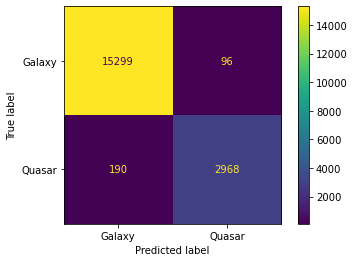

In [212]:
y_pred_knn = pipe_knn_best.predict(x_test)

cm = confusion_matrix(y_test, y_pred_knn)
conf = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels=target_labels
)
conf.plot()
plt.show()